<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/Object%20Localization/Object_Localization_using_resnet50_PASCAL_VOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization

## Data Collection

In [ ]:
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [ ]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Object%20Localization/PASCAL_VOC_labels.p

## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import resnet50
import cv2

In [ ]:
df = pd.read_pickle("/content/PASCAL_VOC_labels.p")
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,6,"[96, 155, 269, 350]"
1,000017.jpg,horse,12,"[77, 89, 335, 402]"
2,000023.jpg,person,14,"[1, 2, 461, 242]"
3,000026.jpg,car,6,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,0,"[77, 103, 182, 374]"


(366, 500, 3)


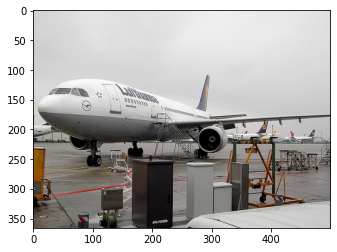

In [ ]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages/"
img = plt.imread(main_folder + df.file_name[5])
print(img.shape)
plt.imshow(img)
plt.show()

[121   7 287 206]
cat


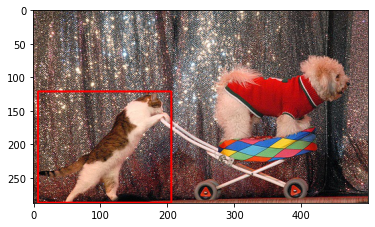

In [ ]:
bb = df.bbox[500]
print(bb)
print(df.category[500])
cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[255,0,0],2)
plt.imshow(img)
plt.show()

In [ ]:
import imgaug
from imgaug import augmenters

In [ ]:
img = plt.imread(main_folder+df.file_name[0])
bb = df.bbox[0]
print(img.shape)
print(bb)
# using imgaug, creating an augmentation object which simply resizes the image (we can make it perform more types of augmentation)
augobj = augmenters.Resize({"height":128,"width":128}).to_deterministic()

# creating a bounding box object using original values of bounding boxes from original image
old_bb = imgaug.BoundingBoxesOnImage([imgaug.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2 = bb[2])],shape=img.shape)

# Using augmentor object, resizing the image to a new image of shape 128x128
new_img = augobj.augment_images([img])[0]
print(new_img.shape)
# using augmentor object to transform the old/original bounding boxes to new bounding boxes corresponding to new image of size 128x28
new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes
print(new_bb)

(333, 500, 3)
[ 96 155 269 350]
(128, 128, 3)
[BoundingBox(x1=39.6800, y1=36.9009, x2=89.6000, y2=103.3994, label=None)]


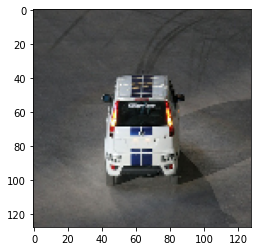

In [ ]:
plt.imshow(new_img)
plt.show()

In [ ]:
new_bb[0].x1

39.68

In [ ]:
def transform(img,bb):
  old_bb = imgaug.BoundingBoxesOnImage([imgaug.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2 = bb[2])],shape=img.shape)
  new_img = augobj.augment_images([img])[0]
  new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes[0]
  new_bb = [new_bb.x1,new_bb.y1,new_bb.x2,new_bb.y2]
  return new_img,new_bb

In [ ]:
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,6,"[96, 155, 269, 350]"
1,000017.jpg,horse,12,"[77, 89, 335, 402]"
2,000023.jpg,person,14,"[1, 2, 461, 242]"
3,000026.jpg,car,6,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,0,"[77, 103, 182, 374]"


In [ ]:
x = []
y1 = []
y2 = []
for i in range(df.shape[0]):
  img_path = main_folder + df.file_name[i]
  img = plt.imread(img_path)
  bb = df.bbox[i]
  img,bb = transform(img,bb)
  img = resnet50.preprocess_input(img)

  x.append(img)
  y1.append(df.cat_id[i])
  y2.append(bb)


In [ ]:
x = np.array(x)
y1 = to_categorical(y1)
y2 = np.array(y2)
print(x.shape)
print(y1.shape)
print(y2.shape)

(2501, 128, 128, 3)
(2501, 20)
(2501, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


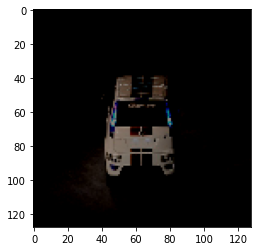

In [ ]:
plt.imshow(x[0].astype('int32'))
plt.show()

## Modelling the Network

In [ ]:
from tensorflow.keras import models,layers

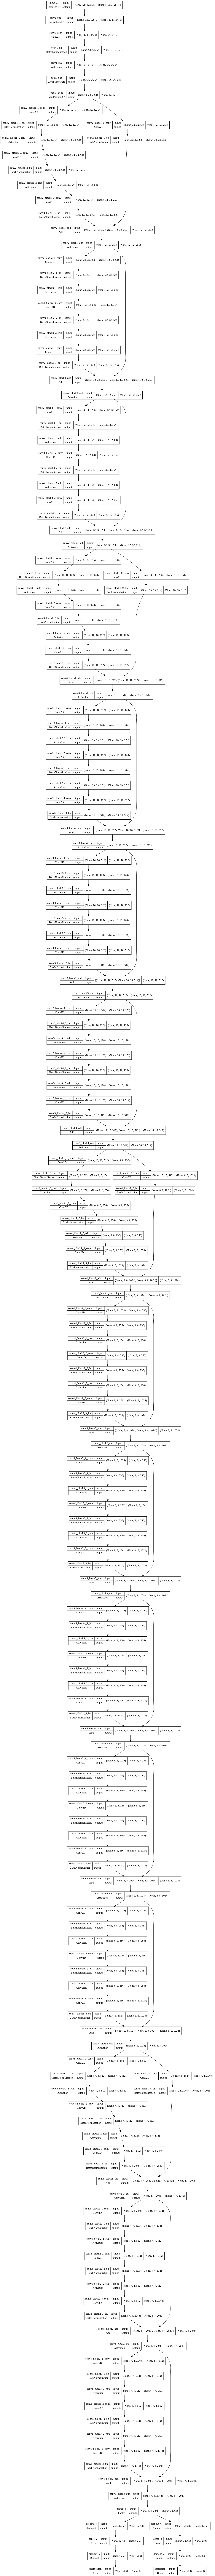

In [ ]:
input_layer = layers.Input(shape=(128,128,3))

resmodel = resnet50.ResNet50(input_tensor=input_layer,include_top=False)


for layer in resmodel.layers[:-5]:
  layer.trainable=False

current_last_layer = resmodel.output

flatten = layers.Flatten()(current_last_layer)

#classification
clf = layers.Dropout(0.25)(flatten)
clf = layers.Dense(250,activation='relu')(clf)
clf = layers.Dropout(0.25)(clf)
clf = layers.Dense(20,activation='softmax',name="classification")(clf)

#regression
reg = layers.Dropout(0.25)(flatten)
reg = layers.Dense(250,activation='relu')(reg)
reg = layers.Dropout(0.25)(reg)
reg = layers.Dense(4,activation='relu',name="regression")(reg)


model = models.Model(inputs=input_layer,outputs=[clf,reg])
plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss={"classification":'categorical_crossentropy','regression':'mae'},
              loss_weights={'classification':3,'regression':2},metrics={'classification':'accuracy'})

model.fit(x=x,y=[y1,y2],epochs=15,batch_size=64,validation_split=0.2,shuffle=True)

Epoch 1/15
32/32 [==============================] - 7s 120ms/step - loss: 59.4147 - classification_loss: 4.2465 - regression_loss: 23.3376 - classification_accuracy: 0.4255 - val_loss: 43.5479 - val_classification_loss: 1.6639 - val_regression_loss: 19.2780 - val_classification_accuracy: 0.5948
Epoch 2/15
32/32 [==============================] - 3s 88ms/step - loss: 35.1539 - classification_loss: 1.0609 - regression_loss: 15.9856 - classification_accuracy: 0.7055 - val_loss: 42.6907 - val_classification_loss: 1.4229 - val_regression_loss: 19.2110 - val_classification_accuracy: 0.6347
Epoch 3/15
32/32 [==============================] - 3s 88ms/step - loss: 31.3670 - classification_loss: 0.5933 - regression_loss: 14.7935 - classification_accuracy: 0.8170 - val_loss: 37.5912 - val_classification_loss: 1.3245 - val_regression_loss: 16.8089 - val_classification_accuracy: 0.6447
Epoch 4/15
32/32 [==============================] - 3s 89ms/step - loss: 28.2639 - classification_loss: 0.3674 - r

In [ ]:
!wget -q https://image.shutterstock.com/image-photo/people-beauty-lifestyle-concept-shot-260nw-662171107.jpg

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img("people-beauty-lifestyle-concept-shot-260nw-662171107.jpg",target_size=(128,128))
img = image.img_to_array(img)

img2 = img.copy()
img = resnet50.preprocess_input(img)

predictions = model.predict(img.reshape(1,128,128,3))
predictions

[array([[7.0390125e-18, 2.0308710e-13, 9.7967804e-17, 1.5307267e-16,
         3.5182784e-17, 6.4781217e-16, 1.8954238e-15, 5.2612943e-16,
         8.5065488e-12, 7.2621256e-17, 4.8703636e-14, 7.2632113e-12,
         4.0441864e-10, 8.1648542e-14, 1.0000000e+00, 5.5513611e-14,
         1.6522786e-15, 7.3343762e-12, 4.2978588e-18, 4.3599506e-17]],
       dtype=float32),
 array([[25.086191 ,  6.3613505, 68.26805  , 96.24965  ]], dtype=float32)]

In [ ]:
cat = np.argmax(predictions[0][0])
print(cat)
df.category[df.cat_id==cat].unique()

14


array(['person'], dtype=object)

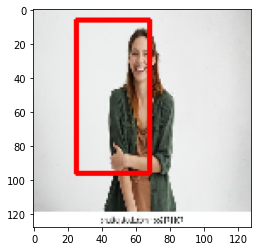

In [ ]:
bb = predictions[1][0]
cv2.rectangle(img2,(bb[0],bb[1]),(bb[2],bb[3]),[255,0,0],2)
plt.imshow(img2.astype('int32'))
plt.show()

In [ ]:
model.save_weights("newcp")

In [ ]:
model.load_weights("newcp")